# Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned.

In [1]:
#Data Structures
import pandas as pd
import numpy as np

#data and model libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from fancyimpute import IterativeImputer as MICE

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.set_theme()

# Step 1. Reading and Understanding data

In [3]:
# read all the csv files (train, test and data dictionary)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(36, 2)


In [4]:
# view data dictionary to understand columns
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belongs to
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile to mobile
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [5]:
# verifying if data read properly
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [6]:
# checking columns, datatypes and if any null values present
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [7]:
# checking range of numeric values and other metrics
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [8]:
# backup original data
original = data.copy()

In [9]:
# divide columns based on datatypes for further processing 

id_cols = ['id', 'circle_id']

date_cols = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']

cat_cols =  ['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']

num_cols = [column for column in data.columns if column not in id_cols + date_cols + cat_cols]

# Step 2. Data Cleaning

## 2.1 Drop unnecessary columns having no contibution to prediction

In [10]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [11]:
# Dropping unnecessary columns having same values for all the observations

unnecessary_columns=['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
for c in unnecessary_columns:
    num_cols.remove(c)
data=data.drop(id_cols + unnecessary_columns,axis=1)

## 2.2 Missing value treatment

In [12]:
# checking % of null values in each column
data.isnull().mean()*100

last_date_of_month_6         0.000000
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_mou_6             3.954342
loc_og_t2m_mou_7             3.838626
loc_og_t2m_mou_8             5.290076
loc_og_t2f_mou_6             3.954342
loc_og_t2f_mou_7             3.838626
loc_og_t2f_m

In [13]:
# Checking columns having more than 40% null values

columns_40_percent_numeric = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

These are all recharge columns, we can say that if value is null, it means that customer has not done recharge for that month. So we can replace it with 0.

In [14]:
# impute missing values with 0

data[columns_40_percent_numeric] = data[columns_40_percent_numeric].apply(lambda x: x.fillna(0))

In [15]:
# impute with category '-1' for missing values in categorical columns (introducing new category)

columns_40_percent_categorical = ['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6','fb_user_7','fb_user_8']

data[columns_40_percent_categorical] = data[columns_40_percent_categorical].apply(lambda x: x.fillna(-1))

In [16]:
# checking for % of null values again`

data.isnull().mean()*100

last_date_of_month_6         0.000000
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_mou_6             3.954342
loc_og_t2m_mou_7             3.838626
loc_og_t2m_mou_8             5.290076
loc_og_t2f_mou_6             3.954342
loc_og_t2f_mou_7             3.838626
loc_og_t2f_m

In [17]:
# Drop date and id columns, since they are of no use for contribution
data = data.drop(date_cols, axis=1)

In [18]:
# impute missing values in the rest of the columns using MICE technique
impute_cols = data.columns

imputed_data = MICE(random_state=10).fit_transform(data)

In [19]:
data = pd.DataFrame(imputed_data, columns=impute_cols)
#data = pd.read_csv('imputed_data.csv')
print(data.isnull().sum()*100/data.shape[0])

arpu_6                0.0
arpu_7                0.0
arpu_8                0.0
onnet_mou_6           0.0
onnet_mou_7           0.0
onnet_mou_8           0.0
offnet_mou_6          0.0
offnet_mou_7          0.0
offnet_mou_8          0.0
roam_ic_mou_6         0.0
roam_ic_mou_7         0.0
roam_ic_mou_8         0.0
roam_og_mou_6         0.0
roam_og_mou_7         0.0
roam_og_mou_8         0.0
loc_og_t2t_mou_6      0.0
loc_og_t2t_mou_7      0.0
loc_og_t2t_mou_8      0.0
loc_og_t2m_mou_6      0.0
loc_og_t2m_mou_7      0.0
loc_og_t2m_mou_8      0.0
loc_og_t2f_mou_6      0.0
loc_og_t2f_mou_7      0.0
loc_og_t2f_mou_8      0.0
loc_og_t2c_mou_6      0.0
loc_og_t2c_mou_7      0.0
loc_og_t2c_mou_8      0.0
loc_og_mou_6          0.0
loc_og_mou_7          0.0
loc_og_mou_8          0.0
std_og_t2t_mou_6      0.0
std_og_t2t_mou_7      0.0
std_og_t2t_mou_8      0.0
std_og_t2m_mou_6      0.0
std_og_t2m_mou_7      0.0
std_og_t2m_mou_8      0.0
std_og_t2f_mou_6      0.0
std_og_t2f_mou_7      0.0
std_og_t2f_m

# Step 3. Data Visualization

In [20]:
data.churn_probability.unique()

array([0., 1.])

In [21]:
# print churn ratio
print("Churn Ratio:")
print(data.churn_probability.astype("category").value_counts()*100/data.shape[0])

Churn Ratio:
0.0    89.811283
1.0    10.188717
Name: churn_probability, dtype: float64


## 3.1 Univariate analysis

In [105]:
import sweetviz as sv
sweet_report = sv.analyze(data,pairwise_analysis="off")
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [107]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 175 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    arpu_6                 float64
 1    arpu_7                 float64
 2    arpu_8                 float64
 3    onnet_mou_6            float64
 4    onnet_mou_7            float64
 5    onnet_mou_8            float64
 6    offnet_mou_6           float64
 7    offnet_mou_7           float64
 8    offnet_mou_8           float64
 9    roam_ic_mou_6          float64
 10   roam_ic_mou_7          float64
 11   roam_ic_mou_8          float64
 12   roam_og_mou_6          float64
 13   roam_og_mou_7          float64
 14   roam_og_mou_8          float64
 15   loc_og_t2t_mou_6       float64
 16   loc_og_t2t_mou_7       float64
 17   loc_og_t2t_mou_8       float64
 18   loc_og_t2m_mou_6       float64
 19   loc_og_t2m_mou_7       float64
 20   loc_og_t2m_mou_8       float64
 21   loc_og_t2f_mou_6       float64
 2

## 3.2 Segmented Univariate Analysis

<Axes: ylabel='Count'>

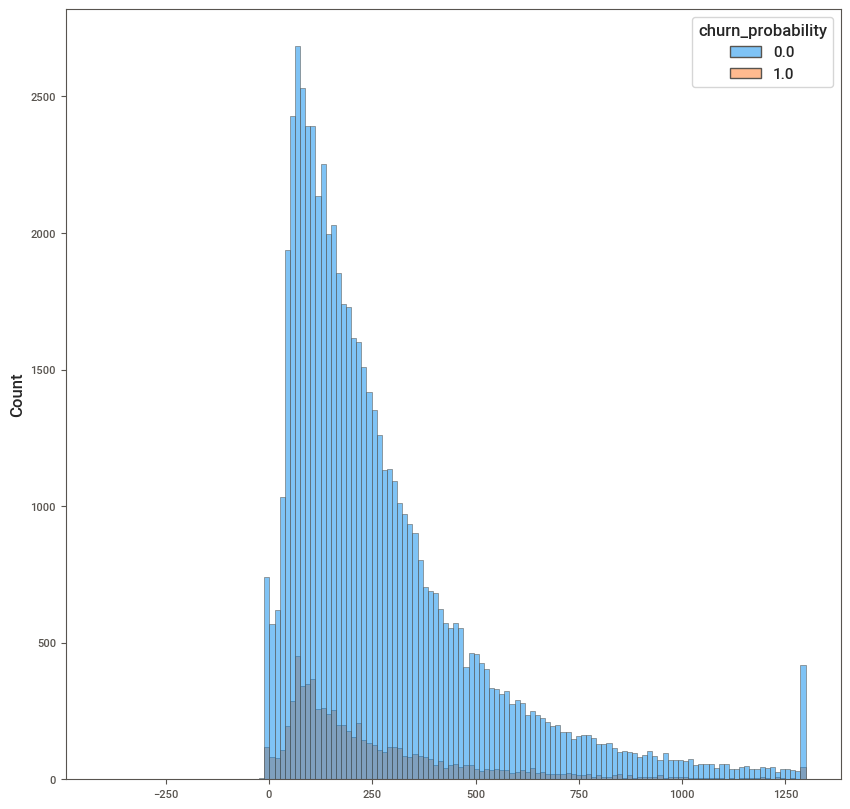

In [112]:
sns.histplot(x=(data.arpu_6+data.arpu_7)/2,hue=data.churn_probability)

<Axes: xlabel='arpu_8', ylabel='Count'>

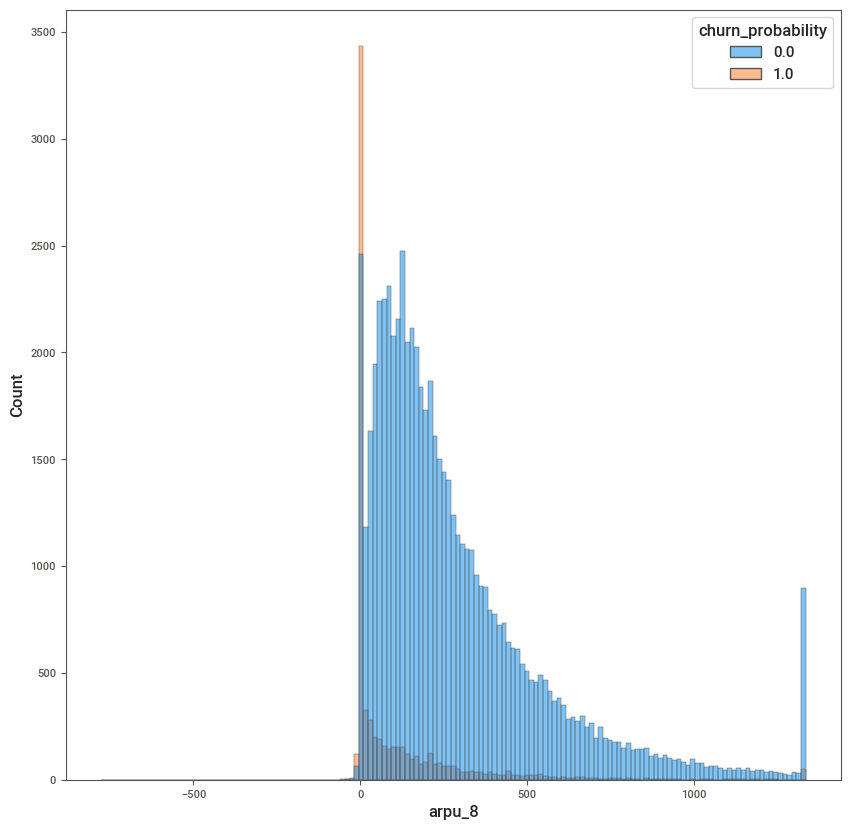

In [113]:
sns.histplot(x=data.arpu_8,hue=data.churn_probability)

<Axes: ylabel='Count'>

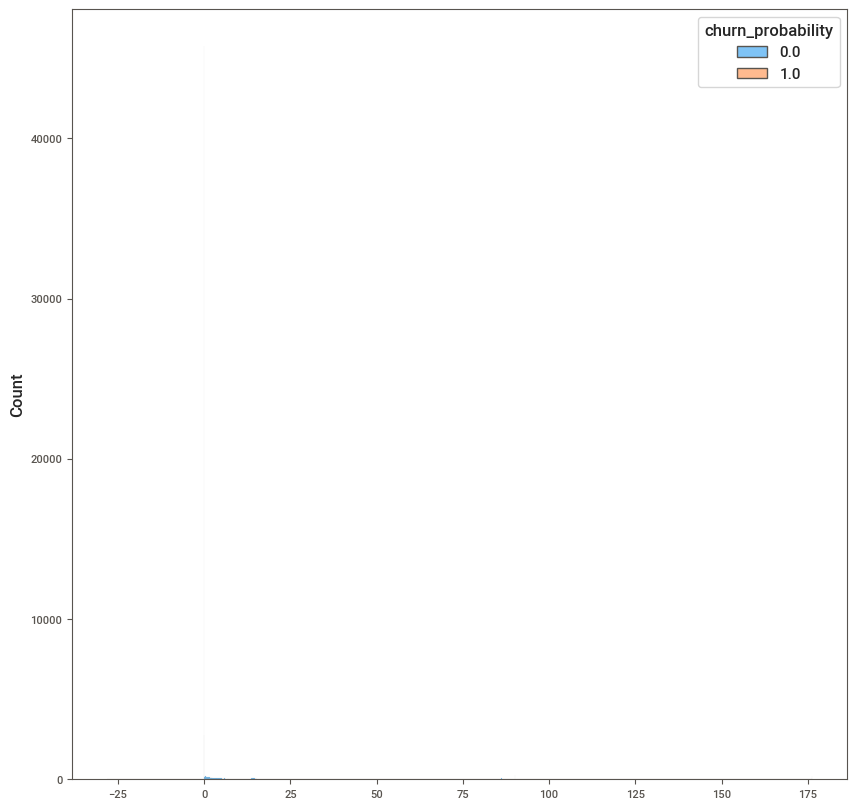

In [119]:
sns.histplot(x=(data.roam_ic_mou_6+data.roam_ic_mou_7)/2,hue=data.churn_probability)

<Axes: xlabel='roam_ic_mou_8', ylabel='Count'>

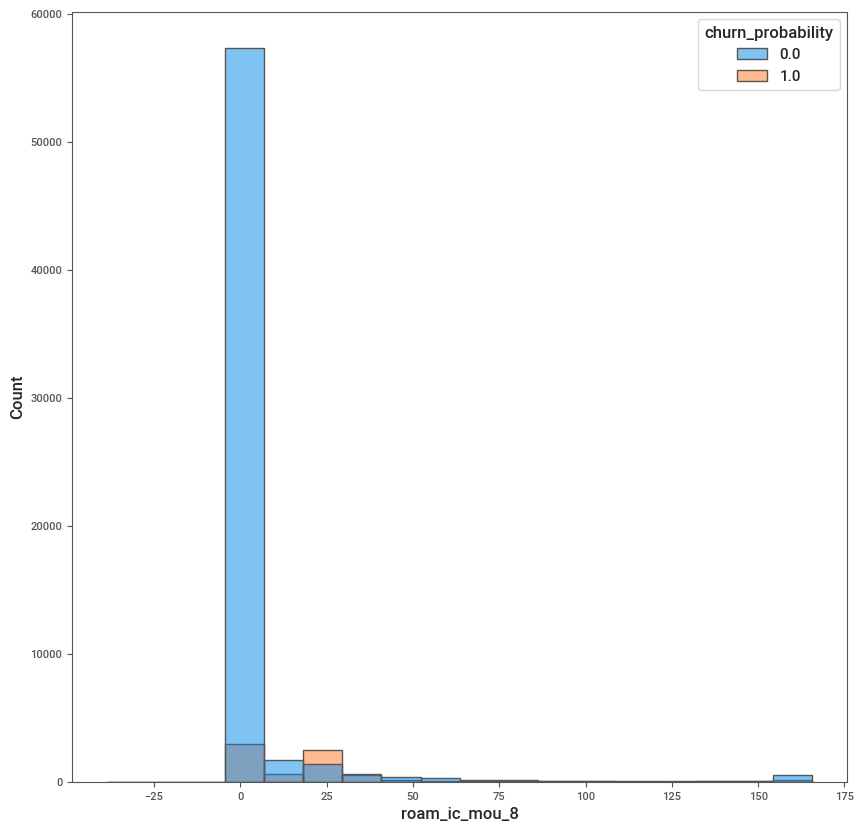

In [120]:
sns.histplot(x=data.roam_ic_mou_8,hue=data.churn_probability)

<Axes: ylabel='Count'>

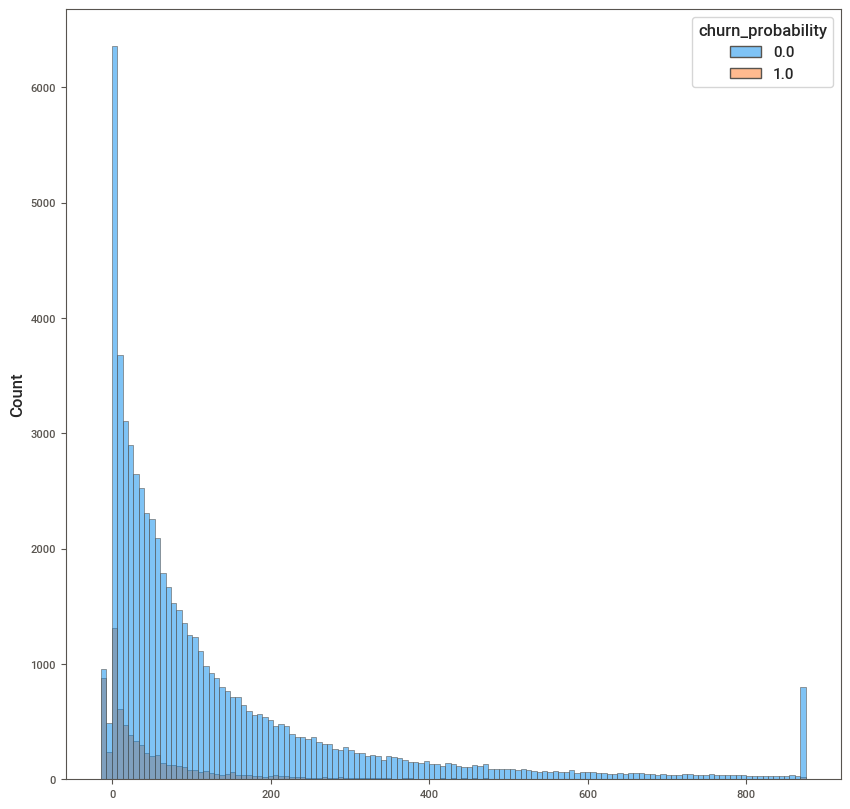

In [121]:
sns.histplot(x=(data.loc_og_mou_6+data.loc_og_mou_7)/2,hue=data.churn_probability)

<Axes: xlabel='loc_og_mou_8', ylabel='Count'>

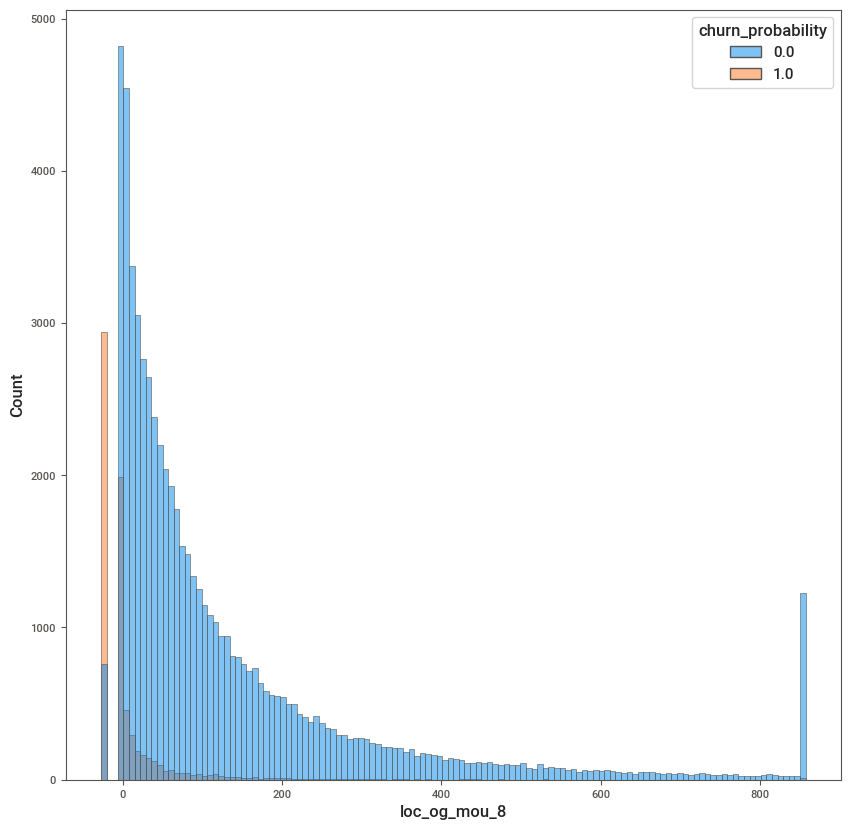

In [122]:
sns.histplot(x=data.loc_og_mou_8,hue=data.churn_probability)

# Step 4. Data Preparation

## 4.1 Derived Columns

We can identify if the customer has stopped/reduced the use of telecom based on his spendings/usage on data/recharge. We can check if his spendings/usage has reduced in the 8th month as compared to the average of 6th and 7th month. We can do this by creating a difference variable between the 8th month and 6th-7th months. We will create such columns for all the data representing customers spendings/usage in some or the other way

In [23]:
data['arpu_diff'] = data.arpu_8 - ((data.arpu_6 + data.arpu_7)/2)

data['onnet_mou_diff'] = data.onnet_mou_8 - ((data.onnet_mou_6 + data.onnet_mou_7)/2)

data['offnet_mou_diff'] = data.offnet_mou_8 - ((data.offnet_mou_6 + data.offnet_mou_7)/2)

data['roam_ic_mou_diff'] = data.roam_ic_mou_8 - ((data.roam_ic_mou_6 + data.roam_ic_mou_7)/2)

data['roam_og_mou_diff'] = data.roam_og_mou_8 - ((data.roam_og_mou_6 + data.roam_og_mou_7)/2)

data['loc_og_mou_diff'] = data.loc_og_mou_8 - ((data.loc_og_mou_6 + data.loc_og_mou_7)/2)

data['std_og_mou_diff'] = data.std_og_mou_8 - ((data.std_og_mou_6 + data.std_og_mou_7)/2)

data['isd_og_mou_diff'] = data.isd_og_mou_8 - ((data.isd_og_mou_6 + data.isd_og_mou_7)/2)

data['spl_og_mou_diff'] = data.spl_og_mou_8 - ((data.spl_og_mou_6 + data.spl_og_mou_7)/2)

data['total_og_mou_diff'] = data.total_og_mou_8 - ((data.total_og_mou_6 + data.total_og_mou_7)/2)

data['loc_ic_mou_diff'] = data.loc_ic_mou_8 - ((data.loc_ic_mou_6 + data.loc_ic_mou_7)/2)

data['std_ic_mou_diff'] = data.std_ic_mou_8 - ((data.std_ic_mou_6 + data.std_ic_mou_7)/2)

data['isd_ic_mou_diff'] = data.isd_ic_mou_8 - ((data.isd_ic_mou_6 + data.isd_ic_mou_7)/2)

data['spl_ic_mou_diff'] = data.spl_ic_mou_8 - ((data.spl_ic_mou_6 + data.spl_ic_mou_7)/2)

data['total_ic_mou_diff'] = data.total_ic_mou_8 - ((data.total_ic_mou_6 + data.total_ic_mou_7)/2)

data['total_rech_num_diff'] = data.total_rech_num_8 - ((data.total_rech_num_6 + data.total_rech_num_7)/2)

data['total_rech_amt_diff'] = data.total_rech_amt_8 - ((data.total_rech_amt_6 + data.total_rech_amt_7)/2)

data['max_rech_amt_diff'] = data.max_rech_amt_8 - ((data.max_rech_amt_6 + data.max_rech_amt_7)/2)

data['total_rech_data_diff'] = data.total_rech_data_8 - ((data.total_rech_data_6 + data.total_rech_data_7)/2)

data['max_rech_data_diff'] = data.max_rech_data_8 - ((data.max_rech_data_6 + data.max_rech_data_7)/2)

data['av_rech_amt_data_diff'] = data.av_rech_amt_data_8 - ((data.av_rech_amt_data_6 + data.av_rech_amt_data_7)/2)

data['vol_2g_mb_diff'] = data.vol_2g_mb_8 - ((data.vol_2g_mb_6 + data.vol_2g_mb_7)/2)

data['vol_3g_mb_diff'] = data.vol_3g_mb_8 - ((data.vol_3g_mb_6 + data.vol_3g_mb_7)/2)

## 4.2 Outlier Treatment

In [24]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [25]:
# cap outliers in the numeric columns
num_cols.remove("churn_probability")
data[num_cols] = data[num_cols].apply(cap_outliers, axis=0)

## 4.3 Train-test split

In [26]:
# divide data into train and test
X = data.drop("churn_probability", axis = 1)
y = data.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [27]:
# print shapes of train and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(52499, 174)
(52499,)
(17500, 174)
(17500,)


# Step 5. Model Building

**We will try following models and decide which one to choose on the basis of their performance on test data:**

1. Logistic Regression with PCA
3. Random Forest

We will also try hyperparameter tuning and cross-validation techniques along with these models.

**PCA to identify best explained variance:**

In [28]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [29]:
#pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [30]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       13.32
1       22.93
2       29.07
3       34.21
4       38.70
5       41.95
6       44.75
7       47.44
8       49.74
9       51.69
10      53.60
11      55.42
12      57.18
13      58.74
14      60.27
15      61.79
16      63.26
17      64.63
18      65.89
19      67.11
20      68.26
21      69.34
22      70.35
23      71.36
24      72.28
25      73.20
26      74.09
27      74.95
28      75.81
29      76.66
30      77.48
31      78.20
32      78.90
33      79.59
34      80.25
35      80.91
36      81.56
37      82.20
38      82.78
39      83.35
40      83.90
41      84.44
42      84.96
43      85.48
44      85.99
45      86.46
46      86.92
47      87.36
48      87.79
49      88.18
50      88.57
51      88.95
52      89.31
53      89.63
54      89.96
55      90.28
56      90.59
57      90.90
58      91.20
59      91.50
60      91.78
61      92.06
62      92.34
63      92.60
64      92.87
65      93.11
66      93.35
67      93.59
68      93.82
69      94.03
70      94.22
71    

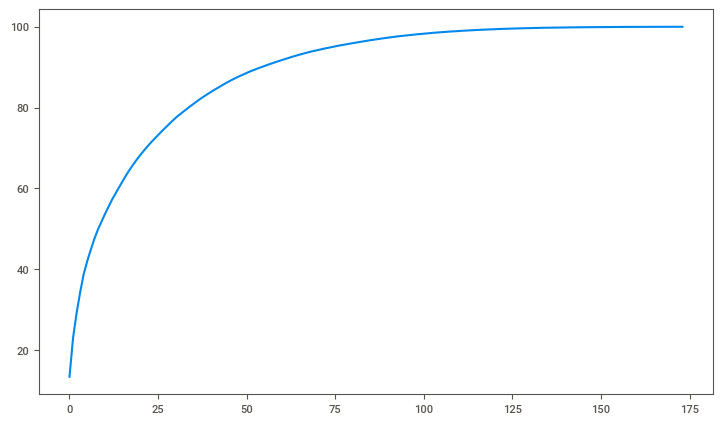

In [31]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(174/20,100/20)) # 100 elements on y-axis; 174 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

* About 90% variance is explained by 60 variables, so we will go ahead with 60 variables right now

## 5.1: M1 - Logistic Regression with PCA

In [32]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline_log_reg_pca = Pipeline(steps)

In [33]:
# fit model
pipeline_log_reg_pca.fit(X_train, y_train)

# check score on train data
pipeline_log_reg_pca.score(X_train, y_train)

0.8627211946894227

In [34]:
# predict churn on test data
y_pred_log_reg_pca = pipeline_log_reg_pca.predict(X_test)

In [35]:
accuracy_score(y_test, y_pred_log_reg_pca, normalize=True)

0.8628571428571429

As we saw earlier, there is class imbalance in the dependent variables. We will address that in next model

In [36]:
# class imbalance
y_train.value_counts()/y_train.shape

0.0    0.898112
1.0    0.101888
Name: churn_probability, dtype: float64

## 5.2: M2 - Logistic Regression with PCA and class imbalance addressed

Building model with class imbalance, hyperparameter tuning and cross-validation

In [37]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_pca_log_reg_class_imb = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [38]:
# fit model
model_pca_log_reg_class_imb.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [39]:
# print best hyperparameters
print("Best AUC: ", model_pca_log_reg_class_imb.best_score_)
print("Best hyperparameters: ", model_pca_log_reg_class_imb.best_params_)

Best AUC:  0.909003074089173
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [41]:
# predict churn on test data
y_pred_pca_log_reg_class_imb = model_pca_log_reg_class_imb.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred_pca_log_reg_class_imb, normalize=True)

0.8578857142857143

## 5.3: M3 - Random Forest

Building Random Forest with hyperparameter tuning and cross-validation

In [43]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_random_forest = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [44]:
# fit model
model_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [45]:
# print best hyperparameters
print("Best AUC: ", model_random_forest.best_score_)
print("Best hyperparameters: ", model_random_forest.best_params_)

Best AUC:  0.9442122445892537
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [47]:
# predict churn on test data
y_pred_random_forest = model_random_forest.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred_random_forest, normalize=True)

0.9489714285714286

# Step 6. Prediction on test data for Kaggle Submission

In [49]:
original_unseen = unseen.copy()

Preparing Test data for transformation

In [50]:
# Dropping unnecessary columns not present in trained data

test_cols=unseen.columns
train_cols=data.columns


col_to_drop = [c for c in test_cols if c not in train_cols]
col_to_drop.remove("id")
col_to_drop

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [51]:
unseen = unseen.drop(col_to_drop,axis=1)

Missing values treatment

In [52]:
unseen[columns_40_percent_categorical] = unseen[columns_40_percent_categorical].apply(lambda x: x.fillna(-1))

In [53]:
unseen[columns_40_percent_numeric] = unseen[columns_40_percent_numeric].apply(lambda x: x.fillna(0))

In [54]:
impute_cols = unseen.columns

# using MICE technique to impute missing values in the rest of the columns
imputed_data = MICE(random_state=10).fit_transform(unseen)

In [55]:
unseen = pd.DataFrame(imputed_data, columns=impute_cols)

Add columns not present in test data

In [56]:
col_to_add = [c for c in train_cols if c not in test_cols]
col_to_add

['churn_probability',
 'arpu_diff',
 'onnet_mou_diff',
 'offnet_mou_diff',
 'roam_ic_mou_diff',
 'roam_og_mou_diff',
 'loc_og_mou_diff',
 'std_og_mou_diff',
 'isd_og_mou_diff',
 'spl_og_mou_diff',
 'total_og_mou_diff',
 'loc_ic_mou_diff',
 'std_ic_mou_diff',
 'isd_ic_mou_diff',
 'spl_ic_mou_diff',
 'total_ic_mou_diff',
 'total_rech_num_diff',
 'total_rech_amt_diff',
 'max_rech_amt_diff',
 'total_rech_data_diff',
 'max_rech_data_diff',
 'av_rech_amt_data_diff',
 'vol_2g_mb_diff',
 'vol_3g_mb_diff']

In [57]:
unseen['arpu_diff'] = unseen.arpu_8 - ((unseen.arpu_6 + unseen.arpu_7)/2)

unseen['onnet_mou_diff'] = unseen.onnet_mou_8 - ((unseen.onnet_mou_6 + unseen.onnet_mou_7)/2)

unseen['offnet_mou_diff'] = unseen.offnet_mou_8 - ((unseen.offnet_mou_6 + unseen.offnet_mou_7)/2)

unseen['roam_ic_mou_diff'] = data.roam_ic_mou_8 - ((data.roam_ic_mou_6 + data.roam_ic_mou_7)/2)

unseen['roam_og_mou_diff'] = data.roam_og_mou_8 - ((data.roam_og_mou_6 + data.roam_og_mou_7)/2)

unseen['loc_og_mou_diff'] = data.loc_og_mou_8 - ((data.loc_og_mou_6 + data.loc_og_mou_7)/2)

unseen['std_og_mou_diff'] = data.std_og_mou_8 - ((data.std_og_mou_6 + data.std_og_mou_7)/2)

unseen['isd_og_mou_diff'] = data.isd_og_mou_8 - ((data.isd_og_mou_6 + data.isd_og_mou_7)/2)

unseen['spl_og_mou_diff'] = data.spl_og_mou_8 - ((data.spl_og_mou_6 + data.spl_og_mou_7)/2)

unseen['total_og_mou_diff'] = data.total_og_mou_8 - ((data.total_og_mou_6 + data.total_og_mou_7)/2)

unseen['loc_ic_mou_diff'] = data.loc_ic_mou_8 - ((data.loc_ic_mou_6 + data.loc_ic_mou_7)/2)

unseen['std_ic_mou_diff'] = data.std_ic_mou_8 - ((data.std_ic_mou_6 + data.std_ic_mou_7)/2)

unseen['isd_ic_mou_diff'] = data.isd_ic_mou_8 - ((data.isd_ic_mou_6 + data.isd_ic_mou_7)/2)

unseen['spl_ic_mou_diff'] = data.spl_ic_mou_8 - ((data.spl_ic_mou_6 + data.spl_ic_mou_7)/2)

unseen['total_ic_mou_diff'] = data.total_ic_mou_8 - ((data.total_ic_mou_6 + data.total_ic_mou_7)/2)

unseen['total_rech_num_diff'] = data.total_rech_num_8 - ((data.total_rech_num_6 + data.total_rech_num_7)/2)

unseen['total_rech_amt_diff'] = data.total_rech_amt_8 - ((data.total_rech_amt_6 + data.total_rech_amt_7)/2)

unseen['max_rech_amt_diff'] = data.max_rech_amt_8 - ((data.max_rech_amt_6 + data.max_rech_amt_7)/2)

unseen['total_rech_data_diff'] = data.total_rech_data_8 - ((data.total_rech_data_6 + data.total_rech_data_7)/2)

unseen['max_rech_data_diff'] = data.max_rech_data_8 - ((data.max_rech_data_6 + data.max_rech_data_7)/2)

unseen['av_rech_amt_data_diff'] = data.av_rech_amt_data_8 - ((data.av_rech_amt_data_6 + data.av_rech_amt_data_7)/2)

unseen['vol_2g_mb_diff'] = data.vol_2g_mb_8 - ((data.vol_2g_mb_6 + data.vol_2g_mb_7)/2)

unseen['vol_3g_mb_diff'] = data.vol_3g_mb_8 - ((data.vol_3g_mb_6 + data.vol_3g_mb_7)/2)

In [58]:
unseen.isnull().mean()*100

id                       0.0
arpu_6                   0.0
arpu_7                   0.0
arpu_8                   0.0
onnet_mou_6              0.0
onnet_mou_7              0.0
onnet_mou_8              0.0
offnet_mou_6             0.0
offnet_mou_7             0.0
offnet_mou_8             0.0
roam_ic_mou_6            0.0
roam_ic_mou_7            0.0
roam_ic_mou_8            0.0
roam_og_mou_6            0.0
roam_og_mou_7            0.0
roam_og_mou_8            0.0
loc_og_t2t_mou_6         0.0
loc_og_t2t_mou_7         0.0
loc_og_t2t_mou_8         0.0
loc_og_t2m_mou_6         0.0
loc_og_t2m_mou_7         0.0
loc_og_t2m_mou_8         0.0
loc_og_t2f_mou_6         0.0
loc_og_t2f_mou_7         0.0
loc_og_t2f_mou_8         0.0
loc_og_t2c_mou_6         0.0
loc_og_t2c_mou_7         0.0
loc_og_t2c_mou_8         0.0
loc_og_mou_6             0.0
loc_og_mou_7             0.0
loc_og_mou_8             0.0
std_og_t2t_mou_6         0.0
std_og_t2t_mou_7         0.0
std_og_t2t_mou_8         0.0
std_og_t2m_mou

Reshape data to match the shape of trained data 

In [59]:
X_train.shape

(52499, 174)

In [60]:
submission_data = unseen.set_index('id')
submission_data.shape

(30000, 174)

In [61]:
submission_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_mou_diff,std_og_mou_diff,isd_og_mou_diff,spl_og_mou_diff,total_og_mou_diff,loc_ic_mou_diff,std_ic_mou_diff,isd_ic_mou_diff,spl_ic_mou_diff,total_ic_mou_diff,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,total_rech_data_diff,max_rech_data_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69999.0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.0,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.0,0.0,0.00,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5.0,5.0,4.0,103.0,90.0,60.0,50.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1692.0,0.00,0.00,0.00,-14.1610,-2.895,-11.330,0.00,0.000,-9.175,-134.030,0.0,-4.415,-147.815,10.70,-2.340,0.0,0.66,8.120,-0.5,-61.0,-55.0,0.000000,0.0,0.0,0.000,0.00
70000.0,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.0,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.0,0.0,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,18

Predict

In [62]:
unseen['churn_probability'] = model_random_forest.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999.0,0.0
1,70000.0,0.0
2,70001.0,1.0
3,70002.0,0.0
4,70003.0,0.0


Transfer to csv file in mentioned format

In [63]:
output.to_csv('submission_khyati_desai_1.csv',index=False)

# Step 7. Checkout models and prediction again for business understanding and identifying important variables 

## 7.1: Feature Importance

In [64]:
features = X_train.columns

In [71]:
importance = model_random_forest.best_estimator_.feature_importances_

In [72]:
# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

In [73]:
feature_importance

,variables,importance_percentage
0,arpu_6,0.515245
1,arpu_7,0.535498
2,arpu_8,0.756638
3,onnet_mou_6,0.417992
4,onnet_mou_7,0.465011
5,onnet_mou_8,0.417651
6,offnet_mou_6,0.437419
7,offnet_mou_7,0.464705
8,offnet_mou_8,0.441352
9,roam_ic_mou_6,0.183298


In [74]:
# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.00000000000001


,variables,importance_percentage
0,total_ic_mou_8,17.993826
1,total_og_mou_8,6.337129
2,loc_ic_t2t_mou_8,5.301351
3,loc_og_mou_8,5.008325
4,loc_ic_mou_8,3.400685
5,roam_og_mou_8,3.359349
6,roam_ic_mou_8,3.214970
7,last_day_rch_amt_8,3.005149
8,loc_ic_t2m_mou_8,1.708354
9,isd_ic_mou_8,1.431485


In [81]:
# extract top 'n' features
top_n = 25
top_features = feature_importance.variables[0:top_n]

<Axes: >

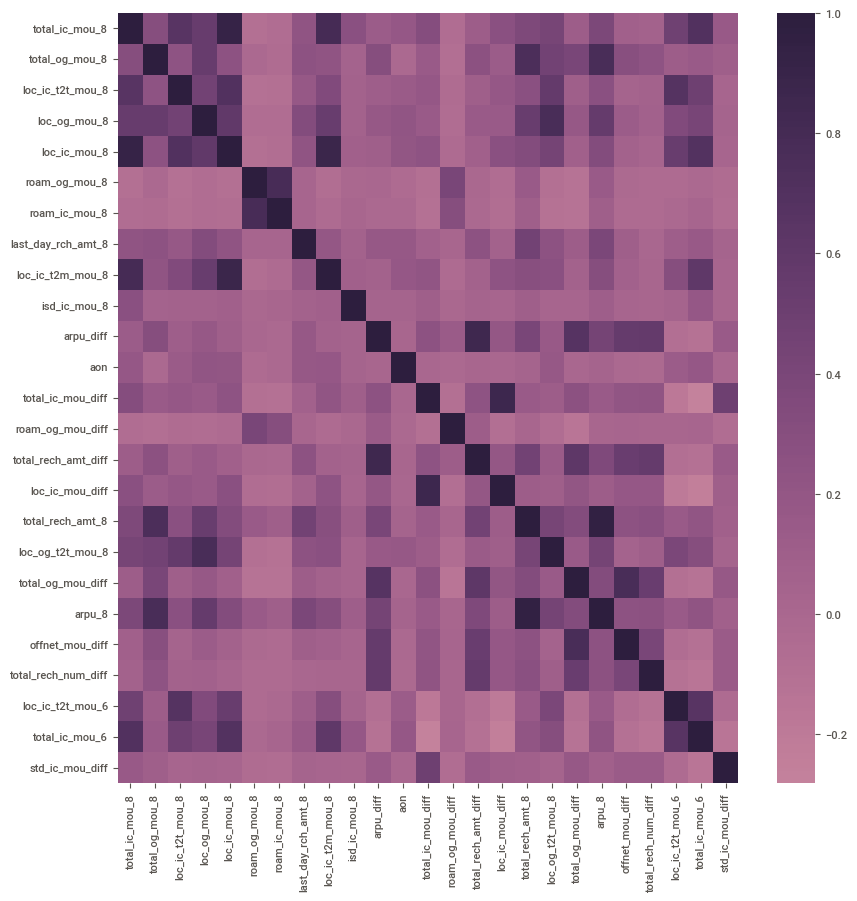

In [85]:
# plot feature correlation
plt.rcParams["figure.figsize"] =(10,10)
#mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap=sns.cubehelix_palette(as_cmap=True))

In [86]:
top_features = ['total_ic_mou_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_og_mou_8', 'loc_ic_mou_8', 'roam_og_mou_8', 
                'roam_ic_mou_8', 'last_day_rch_amt_8', 'loc_ic_t2m_mou_8','isd_ic_mou_8','arpu_diff']
X_train = X_train[top_features]
X_test = X_test[top_features]

In [87]:
# logistic regression
steps = [('scaler', StandardScaler()), 
         ("logistic", LogisticRegression(class_weight={0:0.1, 1:0.9}))
        ]

# compile pipeline
logistic = Pipeline(steps)

# hyperparameter space
params = {'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model_log_reg = GridSearchCV(estimator=logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [88]:
# fit model
model_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [90]:
# print best hyperparameters
print("Best AUC: ", model_log_reg.best_score_)
print("Best hyperparameters: ", model_log_reg.best_params_)

Best AUC:  0.893784002619096
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l2'}


In [92]:
# predict churn on test data
y_pred = model_log_reg.predict(X_test)

In [100]:
logistic_model = model_log_reg.best_estimator_.named_steps['logistic']

In [101]:
# intercept
intercept_df = pd.DataFrame(logistic_model.intercept_.reshape((1,1)), columns = ['intercept'])

In [103]:
# coefficients
logistic_features = list(X_train.columns)
coefficients_df = pd.DataFrame(logistic_model.coef_, columns=logistic_features)

In [104]:
# concatenate dataframes
coefficients = pd.concat([intercept_df, coefficients_df], axis=1)
coefficients

,intercept,total_ic_mou_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_og_mou_8,loc_ic_mou_8,roam_og_mou_8,roam_ic_mou_8,last_day_rch_amt_8,loc_ic_t2m_mou_8,isd_ic_mou_8,arpu_diff
0,-1.303293,-0.796755,-0.000262,-1.003047,-0.535821,0.211476,0.464769,0.184579,-0.575632,-0.021377,0.283662,-0.514987


## Business Insights

* Telecom company needs to pay attention to the their incoming calls policy. Manuy people have spent less and less time on even incoming calls before churning. 
* They also need to check their roaming rates, seems like many people churned after they used the roaming services and maybe were not satisfied.
* Company should ask for customer feedback on both the issues and work towards customer satisfaction